# Training Kalman Filter for Results - 8 Feb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *
from meteo_imp.gaussian import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
from fastcore.foundation import L
from fastcore.foundation import patch
from pathlib import Path, PosixPath

from meteo_imp.kalman.fastai import show_results
import pandas as pd
import numpy as np
import torch
import random
from pyprojroot import here

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

In [ ]:
reset_seed()

In [ ]:
haiB = pd.read_parquet(hai_big_path)
hai_eraB = pd.read_parquet(hai_era_big_path)

In [ ]:
list(haiB.columns)

['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN']

In [ ]:
base = here("analysis/results/trained_8feb")

In [ ]:
base.mkdir(exist_ok=True)

In [ ]:
@patch
def add_end(self: PosixPath, end): return self.parent / (self.name + end)

In [ ]:
def train_or_load(model, dls, lr, n, path, keep=True):
    save_models = SaveModelsBatch(times_epoch=5)
    csv_logger = CSVLogger(path.add_end("log.csv"), append=True)
    learn = Learner(dls, model, KalmanLoss(only_gap=True), cbs = [Float64Callback, save_models, csv_logger], metrics=rmse_gap) 
    items = random.choices(dls.valid.items, k=4) 
    if path.add_end(".pickle").exists() and keep:
        learn.model = torch.load(path.add_end(".pickle"))
        display(csv_logger.read_log())
        plot = Image(filename=path.add_end("_loss_plot.png"))
        display(plot)
        # save_models = torch.load(path.add_end("_save_models.pickle"))
        # learn = torch.load(path.add_end("_learn.pickle"))
    else:
        learn.fit(lr, n)
        
        torch.save(learn.model, path.add_end(".pickle"))
        plt.savefig(path.add_end("_loss_plot.png"))
        # torch.save(save_models, path.add_end("_save_models.pickle"))
        # torch.save(learn, path.add_end("_learn.pickle"))
        learn.recorder.plot_loss()
    return learn, items                           

## All variables - 30 varying 

Model Av (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_Av = imp_dataloader(haiB, hai_eraB, var_sel = gen_var_sel(list(haiB.columns)), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Av = KalmanFilterSR.init_local_slope_pca(len(haiB.columns),len(haiB.columns), df_pca = haiB, pred_only_gap=True, use_conditional=False)

In [ ]:
learn_Av, items_Av = train_or_load(model_Av, dls_Av, 2, 1e-3, base / "All_gap_varying_30_v1.pickle")

In [ ]:
show_results(learn_Av, items=items_Av, control_map=control_map)

## All variables - 30 all

In [ ]:
dls_Aa = imp_dataloader(haiB, hai_eraB, var_sel = list(haiB.columns), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_Aa = model_Av.copy()

epoch,train_loss,valid_loss,rmse_gap,time
0,182.171239,168.446283,0.523671,13:10
1,117.279725,117.592085,0.498368,13:01


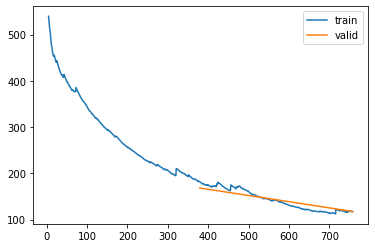

In [ ]:
learn_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 2, 2e-4, base / "All_gap_all_30_v1.pickle")

epoch,train_loss,valid_loss,rmse_gap,time
0,87.858628,92.736614,0.481275,13:27
1,66.078209,78.718438,0.466970,13:12


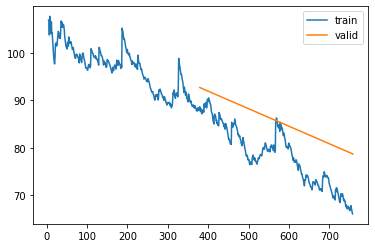

In [ ]:
learn_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 2, 2e-4, base / "All_gap_all_30_v2.pickle")

epoch,train_loss,valid_loss,rmse_gap,time
0,60.024272,72.281475,0.458281,13:22
1,54.344116,65.717688,0.448152,13:14


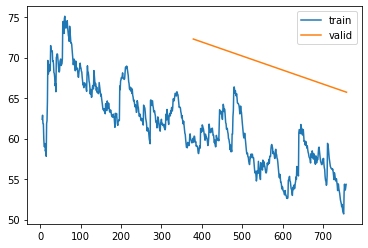

In [ ]:
learn_Aa, save_models_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 2, 2e-4, base / "All_gap_all_30_v3.pickle")

In [ ]:
learn_Aa, items_Aa, csv_logger = train_or_load(model_Aa, dls_Aa, 2, 2e-4, base / "All_gap_all_30_v3.pickle")

In [ ]:
show_results(learn_Aa, items=items_Aa, control_map=control_map)

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


[MeteoImpItem(i=1588, shift=-60, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30), MeteoImpItem(i=1863, shift=12, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30), MeteoImpItem(i=1704, shift=36, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30), MeteoImpItem(i=1545, shift=12, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30)]


alt.HConcatChart(...)

## TA - 30

In [ ]:
dls_TA = imp_dataloader(haiB, hai_eraB, var_sel = 'TA', block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_TA = model_Av.copy()

epoch,train_loss,valid_loss,rmse_gap,time
0,-7.466947,-10.199575,0.141733,11:02
1,-18.349137,-19.333264,0.104535,1:38:44


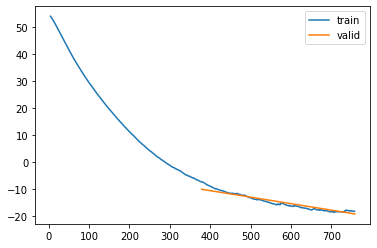

In [ ]:
learn_TA, save_models_TA, items_TA = train_or_load(model_TA, dls_TA, 2, 2e-4, base / "TA_30_v1.pickle")

In [ ]:
learn_TA, items_TA, loggerTA = train_or_load(model_TA, dls_TA, 1, 2e-4, base / "TA_30_v2.pickle")

In [ ]:
loggerTA.read_log()

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-22.20629,-22.448926,0.097302,11:15


In [ ]:
show_results(learn_TA, items=items_TA, control_map=control_map, hide_no_gap=True)

### TA - 96

Model TA

In [ ]:
dls_TA96 = imp_dataloader(haiB, hai_eraB, var_sel = 'TA', block_len=350, gap_len=96, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_TA96 = model_TA.copy()

In [ ]:
learn_TA96, save_models_TA96, items_TA96 = train_or_load(model_TA96, dls_TA96, 2, 2e-4, base / "TA_96_v1.pickle")

In [ ]:
show_results(learn_TA96, items=items_TA96, control_map=control_map, hide_no_gap=True)

## SW_IN - 12

In [ ]:
dls_SW_IN = imp_dataloader(haiB, hai_eraB, var_sel = 'SW_IN', block_len=100, gap_len=12, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_SW_IN = model_Av.copy()

In [ ]:
learn_SW_IN, save_models_SW_IN, items_SW_IN = train_or_load(model_SW_IN, dls_SW_IN, 2, 2e-4, base / "SW_IN_12_v1.pickle")

In [ ]:
show_results(learn_SW_IN, items=items_SW_IN, control_map=control_map, hide_no_gap=True)

### SW_IN - 96

Model SW_IN (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_SW_IN96 = imp_dataloader(haiB, hai_eraB, var_sel = 'SW_IN', block_len=350, gap_len=96, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_SW_IN96 = model_SW_IN.copy()

In [ ]:
learn_SW_IN96, save_models_SW_IN96, items_SW_IN96 = train_or_load(model_SW_IN96, dls_SW_IN96, 2, 2e-4, base / "SW_IN_96_v1.pickle")

In [ ]:
show_results(learn_SW_IN96, items=items_SW_IN96, control_map=control_map, hide_no_gap=True)

## LW_IN - 12

In [ ]:
dls_LW_IN = imp_dataloader(haiB, hai_eraB, var_sel = 'LW_IN', block_len=100, gap_len=12, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_LW_IN = model_Av.copy()

In [ ]:
learn_LW_IN, save_models_LW_IN, items_LW_IN = train_or_load(model_LW_IN, dls_LW_IN, 2, 2e-4, base / "LW_IN_12_v1.pickle")

In [ ]:
show_results(learn_LW_IN, items=items_LW_IN, control_map=control_map, hide_no_gap=True)

### LW_IN - 96

Model LW_IN (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_LW_IN96 = imp_dataloader(haiB, hai_eraB, var_sel = 'LW_IN', block_len=350, gap_len=96, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_LW_IN96 = model_LW_IN.copy()

In [ ]:
learn_LW_IN96, save_models_LW_IN96, items_LW_IN96 = train_or_load(model_LW_IN96, dls_LW_IN96, 2, 2e-4, base / "LW_IN_96_v1.pickle")

In [ ]:
show_results(learn_LW_IN96, items=items_LW_IN96, control_map=control_map, hide_no_gap=True)

## No Control

### All variables - 30 varying 

Model Av_nc (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_Av_nc = imp_dataloader(haiB, 
                           control = hai_eraB.sample(frac=1).reset_index(drop=True).set_index(hai_eraB.index), #reshuffle so cannot use control
                           var_sel = gen_var_sel(list(haiB.columns)), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Av_nc = model_Av.copy()
model_Av_nc.use_control = False

epoch,train_loss,valid_loss,rmse_gap,time
0,51.306504,49.708980,0.438821,36:44


ValueError: too many values to unpack (expected 2)

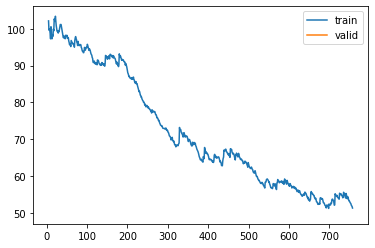

In [ ]:
learn_Av_nc, items_Av_nc = train_or_load(model_Av_nc, dls_Av_nc, 1, 5e-4, base / "All_gap_varying_30_no_control_v1.pickle")

In [ ]:
learn_Av_nc, items_Av_nc = train_or_load(model_Av_nc, dls_Av_nc, 1, 1e-3, base / "All_gap_varying_30_no_control_v2.pickle")

epoch,train_loss,valid_loss,rmse_gap,time


In [ ]:
show_results(learn_Av_nc, items=items_Av_nc, control_map=control_map)